In [245]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json

from numba import jit

In [2]:
# Import input files
weightsParam = pd.read_csv('../Data/EmpiricalWeightParameters.txt',delimiter='\t',encoding='utf-8')
thresholdParam = pd.read_csv('../Data/EmpiricalThresholdParameters.txt',delimiter=',',encoding='utf-8').set_index("var")

# Set right index
keyArr = np.array(weightsParam.keys())
weightsParam = weightsParam.set_index(keyArr)

The formal dynamic systems model of MD
--------------------------------------

We begin developing the formal model of MD by assuming the following: 1) symptoms (Xi) can be ‘on’ (1; active) or ‘off’ (0; inactive); 2) symptom activation takes place over time (t) such that, for example, insomnia at timetmay cause activation of fatigue at timet+ 1; and 3) a symptom ireceives input from symptoms with which it is connected in the VATSPUD data (i.e., these are non-zero weight parameters). These weight parameters are collected in a matrix **W** for the J=14 symptoms: entry $\mathbf{W}_{ij}$ thus represents the logistic regression weight between symptomsiandjas estimated from the VATSPUD data (as one can see in Fig 2 the weight parameters from the data are used in the subsequent simulations with our model). Model formulation now proceeds along the following steps: 

#### Total Activation Function
We assume that the total amount of activation a symptom *i* receives at time *t* is the weighted (by **W**) summation of all the neighboring symptoms **X** (i.e., the vector that contains the “0” and “1” values of being inactive and active respectively) at timet– 1. We call this the *total activation function* (boldfaced parameters are estimated from the VATSPUD data):

$A^t_i = \sum^J_{j=1} \mathbf{W}_{ij}X_j^{t-1}$

#### Probability Function
We formulate a logistic function for computing the probability of symptomibecoming active at timet: the probability of symptomibecoming active at timetdepends on the difference between the total activation of its neighboring symptoms and the threshold of symptomi(in the formula below: $(b_i—A_i^t)$). This threshold is estimated from the VATSPUD data (see also Fig 2). Note that the parameter $\mathbf{b}_i$ denotes the absolute value of these estimated thresholds. The more the total activation exceeds the threshold of symptomiat timet, the higher the probability that symptomibecomes active (in the formula below: $P(X_i^t = 1)$) at timet. We call this the *probability function* (boldfaced parameters are estimated from the VATSPUD data):

$P(X_i^t=1) = \frac{1}{1+e^{\mathbf{b_i}-A_i^t}}$

**The simulation study**. To investigate our vulnerability hypothesis, we inserted a connectivity parameter *c* with which matrix **$W$** is multiplied. This results in the following modified *total activation function*:

$A^t_i = \sum^J_{j=1} c\mathbf{W}_{ij}X_j^{t-1}$

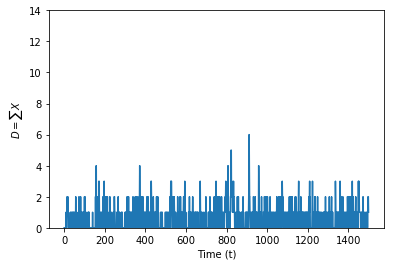

In [258]:
# Simulation 1

I = 1500

W = np.asarray(weightsParam)
b = np.abs(np.asarray(thresholdParam).ravel())
X = np.zeros(b.shape, np.bool)

c = 0.8

D = np.empty(I, np.uint8)

for i in range(I):
    A = np.sum(c*W*X, axis=1)
    P = 1 / (1 + np.exp(b-A))
    X = P > np.random.uniform(0, 1, P.shape)
    
    D[i] = np.sum(X)

plt.plot(D)
plt.xlabel("Time (t)")
plt.ylabel("$D = \sum X$")
plt.ylim(0, 14)
plt.axis('on')
plt.show()

For the sake of simplicity, we assumed that stress influenced all symptoms in an equal manner (see left part of Fig 6, a visualization of the setup of Simulation II). To this end, we extended our formal model of MD–see Methods of Simulation I–with a stress parameter $S_i^t$, a number that was added to the total activation of the neighbors of symptomiat timet: the higher $S_i^t$–that is, the more stress–the higher the total activation function, and thus the higher the probability that symptom *i* will become active at time *t*. This results in the following modified *total activation function*:


$A^t_i = \sum^J_{j=1} c\mathbf{W}_{ij}X_j^{t-1} + S_i^t$

150/150

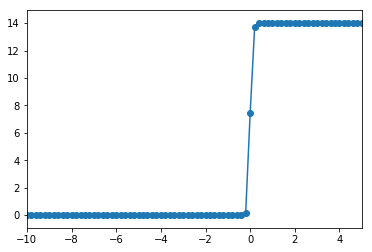

In [261]:
def simulation_2():    
    W = np.asarray(weightsParam)
    b = np.abs(np.asarray(thresholdParam).ravel())
    X = np.zeros(b.shape, np.bool)

    OUTER_STEPSIZE = 0.2
    INNER_STEPSIZE = 0.01
    
    OUTER_S = np.arange(-15, 15, OUTER_STEPSIZE)
    INNER_S = np.arange(0, OUTER_STEPSIZE, INNER_STEPSIZE)
    
    D = np.empty(OUTER_S.shape)
    
    return _simulation_2(W, b, X, D, OUTER_S, INNER_S)

# @jit(nopython=True)
def _simulation_2(W, b, X, D, OUTER_S, INNER_S):
    c = 0.8
    I = 1000
    AVERAGE_ITERATIONS = 500
    
    for SI, S in enumerate(OUTER_S):
        print("\r{}/{}".format(SI+1, len(OUTER_S)), end="")
        
        d = 0.0

        for s in INNER_S:
            
            W = np.asarray(weightsParam)
            b = np.abs(np.asarray(thresholdParam).ravel())
            X = np.zeros(b.shape, np.bool)
            
            stress = S+s

            for i in range(I-AVERAGE_ITERATIONS):
                A = np.sum(c*W*X + stress, axis=1)
                P = 1 / (1 + np.exp(b-A))
                X = P > np.random.uniform(0, 1, P.shape)
                
            for i in range(AVERAGE_ITERATIONS):
                A = np.sum(c*W*X + stress, axis=1)
                P = 1 / (1 + np.exp(b-A))
                X = P > np.random.uniform(0, 1, P.shape)

                d += np.sum(X)

        D[SI] = d / (len(INNER_S) * AVERAGE_ITERATIONS)
    
    return D


D = simulation_2()

plt.plot(OUTER_S, D)
plt.scatter(OUTER_S, D)
plt.xlim(-10, 5)
plt.show()

In [3]:
# Init 
G = nx.Graph()
thresholds = {}
activationValues = {}
stateValues = {}

# Code for dataframe straight to graph (not enough options)
G = nx.from_pandas_adjacency(weightsParam)

In [4]:
# Fill graph
for key in keyArr:
    thresholds[key] = thresholdParam.at[key, "threshold"]
    activationValues[key] = 0
    stateValues[key] = 0

# Fill node attributes
nx.set_node_attributes(G, thresholds, name="threshold")
nx.set_node_attributes(G, startingValues, name="activationValues")
nx.set_node_attributes(G, stateValues, name="stateValues")

In [5]:
# Fucking around with layout????
# ?? nx.spring_layout

#     for index, row in weightsParam.iterrows():
#         if key != index and row[key] != 0:
#             G.add_edge(index, key, weight=row[key])

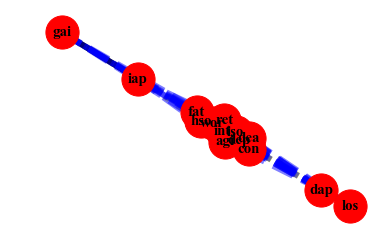

In [6]:
# Create bins for different edges
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1.5]
emedium = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 1.5 and d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=emedium,
                       width=6, alpha=0.5, edge_color='y', style='dotted')
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=15, font_family='Times New Roman')
nx.spring_layout(G, k=None, pos=None, fixed=None, iterations=50, threshold=0.00001, weight='weight', scale=4, center=None, dim=2, random_state=None)

plt.axis('off')
plt.show()

In [7]:
# Some extra info for checking
print(G.number_of_nodes())
print(G.nodes())
print(G.number_of_edges())
print(G.edges())
print(G.neighbors("dep"))
print(G.node["int"]["threshold"])
nx.draw(G)

14
['dep', 'int', 'los', 'gai', 'dap', 'iap', 'iso', 'hso', 'agi', 'ret', 'fat', 'wor', 'con', 'dea']
73
[('dep', 'int'), ('dep', 'los'), ('dep', 'gai'), ('dep', 'dap'), ('dep', 'iap'), ('dep', 'iso'), ('dep', 'hso'), ('dep', 'agi'), ('dep', 'ret'), ('dep', 'fat'), ('dep', 'wor'), ('dep', 'con'), ('dep', 'dea'), ('int', 'los'), ('int', 'gai'), ('int', 'dap'), ('int', 'iap'), ('int', 'iso'), ('int', 'hso'), ('int', 'agi'), ('int', 'ret'), ('int', 'fat'), ('int', 'wor'), ('int', 'con'), ('int', 'dea'), ('los', 'gai'), ('los', 'dap'), ('los', 'iso'), ('los', 'wor'), ('los', 'con'), ('los', 'dea'), ('gai', 'dap'), ('gai', 'iap'), ('gai', 'iso'), ('gai', 'hso'), ('gai', 'fat'), ('gai', 'wor'), ('dap', 'iso'), ('dap', 'hso'), ('dap', 'agi'), ('dap', 'ret'), ('dap', 'fat'), ('dap', 'wor'), ('dap', 'con'), ('dap', 'dea'), ('iap', 'hso'), ('iap', 'agi'), ('iap', 'ret'), ('iap', 'fat'), ('iap', 'dea'), ('iso', 'hso'), ('iso', 'agi'), ('iso', 'fat'), ('iso', 'con'), ('iso', 'dea'), ('hso', 'ret')

In [8]:
# To json format for site
data = nx.json_graph.node_link_data(G)
with open('data.json', 'w') as outfile:
    json.dump(data, outfile)